# Статистический анализ датасета по теннису

In [1]:
# импорт всех необходимых библиотек
import requests
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import re
import numpy as np
import scipy.stats as stats
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [2]:
# Загрузка файлов из репозитория GitHub в локальную папку

# URL репозитория
repo_url = 'https://github.com/JeffSackmann/tennis_atp'

# Папка, в которой находятся файлы
folder_path = 'blob/master/'

# Директория для сохранения файлов
save_dir = 'data/atp_matches'

# Создаем директорию, если она не существует
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Создаем сессию requests
with requests.Session() as session:
    # Получаем страницу репозитория с файлами
    response = session.get(f'{repo_url}/{folder_path}')
    if response.ok:
        # Используем BeautifulSoup для парсинга HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Ищем все ссылки на csv файлы, которые соответствуют маске
        regex = re.compile(r'atp_matches_\d{4}\.csv')
        for a in soup.find_all('a', href=True):
            if regex.match(a.text):
                # Строим URL файла
                file_url = f'https://github.com{a["href"]}'
                # Превращаем ссылку на просмотр в ссылку на скачивание
                raw_url = file_url.replace('/blob/', '/raw/')
                # Скачиваем файл
                file_response = session.get(raw_url)
                if file_response.ok:
                    # Сохраняем содержимое файла
                    file_name = os.path.join(save_dir, a.text)
                    with open(file_name, 'wb') as file:
                        file.write(file_response.content)
                else:
                    print(f'Failed to download {a.text}')
    else:
        print('Failed to retrieve the repository page')

In [3]:
# Инициализация словаря для хранения датасетов
datasets = {}

# Цикл по годам от 1968 до 2023 включительно
for year in range(1968, 2024):
    file_name = f'data/atp_matches/atp_matches_{year}.csv'
    datasets[year] = pd.read_csv(file_name)

In [4]:
# список столбцов, по которым будет идти объединение
columns = list(datasets[2000].columns)

In [5]:
# Список для хранения отфильтрованных датасетов
filtered_datasets = []

# Проходим по всем датасетам в словаре
for year, df in datasets.items():
    # Выбираем только столбцы из списка columns
    filtered_df = df[columns]
    # Добавляем отфильтрованный датасет в список
    filtered_datasets.append(filtered_df)

# Объединяем все отфильтрованные датасеты в один
combined_df = pd.concat(filtered_datasets, ignore_index=True)

In [6]:
combined_df.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
136756,2005-315,Newport,Grass,32.0,A,20050704,6,103503,NaN,NaN,...,40.0,32.0,22.0,13.0,5.0,8.0,110.0,386.0,157.0,267.0
24137,1974-410,Monte Carlo WCT,Clay,32.0,A,19740408,27,100060,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,23.0,NaN
307,1968-416,Rome,Clay,128.0,M,19680506,58,106971,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88308,1991-520,Roland Garros,Clay,128.0,G,19910527,49,101098,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1589.0,84.0,445.0
90010,1991-375,Lyon,Carpet,32.0,A,19911014,7,100870,NaN,NaN,...,41.0,27.0,14.0,9.0,11.0,15.0,92.0,405.0,59.0,530.0
119400,1999-560,US Open,Hard,128.0,G,19990830,54,102466,NaN,NaN,...,99.0,60.0,18.0,19.0,9.0,14.0,58.0,759.0,312.0,124.0
3320,1968-9335,Indianapolis,Clay,64.0,A,19680708,240,109999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127209,2002-328,Basel,Carpet,32.0,A,20021021,7,103484,NaN,NaN,...,48.0,31.0,17.0,10.0,8.0,10.0,27.0,1185.0,60.0,645.0
90169,1991-215,Buzios,Hard,32.0,A,19911028,26,101462,NaN,NaN,...,80.0,45.0,8.0,14.0,10.0,15.0,183.0,183.0,35.0,798.0
158655,2012-580,Australian Open,Hard,128.0,G,20120116,43,105023,NaN,NaN,...,37.0,26.0,12.0,12.0,3.0,8.0,95.0,589.0,135.0,400.0


## Изучение датасета

In [7]:
df = combined_df.copy()

In [11]:
# Вывод информации о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191920 entries, 0 to 191919
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          191920 non-null  object 
 1   tourney_name        191920 non-null  object 
 2   surface             188930 non-null  object 
 3   draw_size           191085 non-null  float64
 4   tourney_level       191920 non-null  object 
 5   tourney_date        191920 non-null  int64  
 6   match_num           191920 non-null  int64  
 7   winner_id           191920 non-null  int64  
 8   winner_seed         70926 non-null   float64
 9   winner_entry        16743 non-null   object 
 10  winner_name         191920 non-null  object 
 11  winner_hand         191910 non-null  object 
 12  winner_ht           175012 non-null  float64
 13  winner_ioc          191912 non-null  object 
 14  winner_age          190610 non-null  float64
 15  loser_id            191920 non-nul

## Подготовка данных 

In [12]:
# Выделяем год из столбца даты турнира
df['tourney_year'] = df['tourney_date'].apply(lambda x: int(str(x)[:4]))

In [13]:
# изучение пропусков
df.isnull().sum()

tourney_id                 0
tourney_name               0
surface                 2990
draw_size                835
tourney_level              0
tourney_date               0
match_num                  0
winner_id                  0
winner_seed           120994
winner_entry          175177
winner_name                0
winner_hand               10
winner_ht              16908
winner_ioc                 8
winner_age              1310
loser_id                   0
loser_seed            155821
loser_entry           163496
loser_name                 0
loser_hand                49
loser_ht               29660
loser_ioc                 72
loser_age               4654
score                      9
best_of                    0
round                      0
minutes                99653
w_ace                  96885
w_df                   96886
w_svpt                 96886
w_1stIn                96886
w_1stWon               96886
w_2ndWon               96886
w_SvGms                96885
w_bpSaved     

In [14]:
# проверка на пропуски: целевая доля пропусков - 60%
missing_value_threshold = 0.6
columns_with_missing_values = df.columns[df.isnull()
                                         .mean() > missing_value_threshold].tolist()
len(columns_with_missing_values)
# в датасете 25 колонок с пропусками более 60%

4

In [15]:
# удаляем столбцы с пропусками более 60% из всех датасетов

threshold = 0.6  # целевая доля - 60%
cols_to_drop = df.columns[df.isnull().mean() > threshold]
# Удаляем эти столбцы из датасета и перезаписываем в новый
df_1 = df.drop(cols_to_drop, axis=1, inplace=False)

In [16]:
# цикл по всем датасетам для поиска дубликатов
dupl_columns = list(df_1.columns)
# булевая маска для фильтрации, subset - список признаков, по которым идет поиск дубликатов
mask = df_1.duplicated(subset=dupl_columns)
# количество дубликатов в текущем датасете
num_duplicates = df_1[mask].shape[0]
if num_duplicates == 0:
    print("Дубликатов нет")

Дубликатов нет


In [17]:
# Удаление строк, где winner_rank или loser_rank являются NaN
df_1 = df_1.dropna(subset=['winner_rank', 'loser_rank'])

## Задание 1

Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждения:

а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

In [18]:
df1 = df_1.copy()

In [19]:
# Выделяем только нужные признаки
df1 = df1[['winner_id', 'winner_rank', 'loser_id', 'loser_rank']]

# Создаем выборки по заданным критериям (раг отличается больше и меньше чем на 20 позиций)
more20 = df1[abs(df1['winner_rank'] - df1['loser_rank']) > 20]
less20 = df1[abs(df1['winner_rank'] - df1['loser_rank']) <= 20]

In [20]:
more20.head(3)

,winner_id,winner_rank,loser_id,loser_rank
18086,100119,1.0,100129,88.0
18087,100304,193.0,100067,71.0
18088,100135,39.0,100376,118.0


In [21]:
# Считаем количество побед в первой выборке
more20_wins = more20['winner_id'].value_counts().reset_index()
more20_wins.rename(columns={'winner_id': 'id', 'count': 'wins'}, inplace=True)
more20_wins.head(3)

,id,wins
0,103819,821
1,104745,694
2,104925,661


In [22]:
# Считаем количество проигрышей в первой выборке
more20_loses = more20['loser_id'].value_counts().reset_index()
more20_loses.rename(columns={'loser_id': 'id', 'count': 'loses'}, inplace=True)
more20_loses.head(3)

,id,loses
0,103852,304
1,102148,303
2,104312,287


In [23]:
# Объединяем датасеты по столбцу id и считаем общее кол-во игр, ожидаемое кол-во побед (общее кол-во игр * 0.5),
# отклонение от фактического от ожидаемого кол-во побед
# столбец more20 для обозначения разницы в ранге более 20 ((1 - разнца больше 20))
combined_more20 = pd.merge(more20_wins, more20_loses, on='id', how='outer')
combined_more20['wins'].fillna(0, inplace=True)
combined_more20['loses'].fillna(0, inplace=True)
combined_more20['total'] = combined_more20['wins'] + combined_more20['loses']
combined_more20['expected_wins'] = combined_more20['total'] * 0.5
combined_more20['deviation'] = combined_more20['wins'] - \
    combined_more20['expected_wins']
combined_more20['more20'] = 1
combined_more20.head()

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\2619386588.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_more20['wins'].fillna(0, inplace=True)
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\2619386588.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



,id,wins,loses,total,expected_wins,deviation,more20
0,100003,1.0,2.0,3.0,1.5,-0.5,1
1,100005,1.0,2.0,3.0,1.5,-0.5,1
2,100006,0.0,1.0,1.0,0.5,-0.5,1
3,100011,3.0,17.0,20.0,10.0,-7.0,1
4,100013,1.0,4.0,5.0,2.5,-1.5,1


In [24]:
# Считаем количество выигрышей во второй выборке
less20_wins = less20['winner_id'].value_counts().reset_index()
less20_wins.rename(columns={'winner_id': 'id', 'count': 'wins'}, inplace=True)
less20_wins.head(3)

,id,wins
0,103819,441
1,104925,437
2,104745,385


In [25]:
# Считаем количество проигрышей во второй выборке
less20_loses = less20['loser_id'].value_counts().reset_index()
less20_loses.rename(columns={'loser_id': 'id', 'count': 'loses'}, inplace=True)
less20_loses.head(3)

,id,loses
0,104607,200
1,103852,188
2,103970,188


In [26]:
# Объединяем датасеты по столбцу id и считаем общее кол-во игр, ожидаемое кол-во побед (общее кол-во игр * 0.5),
# отклонение от фактического от ожидаемого кол-во побед
# столбец more20 для обозначения разницы в ранге более 20 (0 - разнца меньше 20)
combined_less20 = pd.merge(less20_wins, less20_loses, on='id', how='outer')
combined_less20['wins'].fillna(0, inplace=True)
combined_less20['loses'].fillna(0, inplace=True)
combined_less20['total'] = combined_less20['wins'] + combined_less20['loses']
combined_less20['expected_wins'] = combined_less20['total'] * 0.5
combined_less20['deviation'] = combined_less20['wins'] - \
    combined_less20['expected_wins']
combined_less20['more20'] = 0
combined_less20.head()

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\2127005291.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_less20['wins'].fillna(0, inplace=True)
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\2127005291.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



,id,wins,loses,total,expected_wins,deviation,more20
0,100011,1.0,2.0,3.0,1.5,-0.5,0
1,100016,29.0,41.0,70.0,35.0,-6.0,0
2,100017,0.0,1.0,1.0,0.5,-0.5,0
3,100022,6.0,5.0,11.0,5.5,0.5,0
4,100024,2.0,1.0,3.0,1.5,0.5,0


In [27]:
# Расчет среднего отклонения в выборках
# Функция принимает на вход столбец датасета - df_col, по которому рассчитывается отклонение

def deviation_function(df_col):
    mean = np.mean(df_col)
    absolute_deviations = np.absolute(df_col - mean)
    mean_absolute_deviation = np.mean(absolute_deviations)
    return round(mean_absolute_deviation, 3)

In [28]:
print(
    f'Среднее отклонение в первой выборке: {deviation_function(combined_more20["deviation"])}')

print(
    f'Среднее отклонение во второй выборке: {deviation_function(combined_less20["deviation"])}')

Среднее отклонение в первой выборке: 7.228
Среднее отклонение во второй выборке: 2.967


Среднее отклонение в первой выборке превышает таковое во второй выборке 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


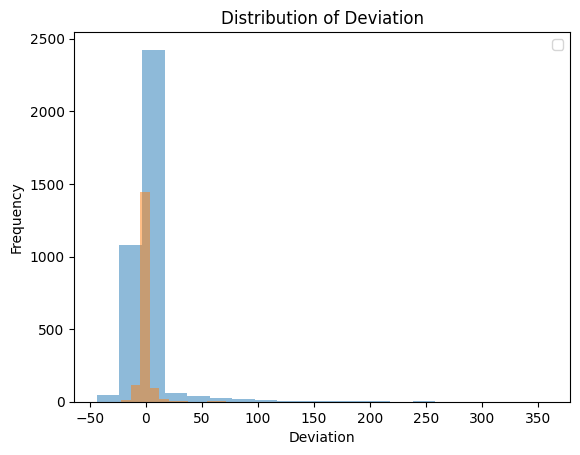

In [29]:
# Построение гистограммы для lower_rank_players
plt.hist(combined_more20['deviation'], bins=20, alpha=0.5)
plt.hist(combined_less20['deviation'], bins=20, alpha=0.5)

plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation')
plt.legend()

plt.show()

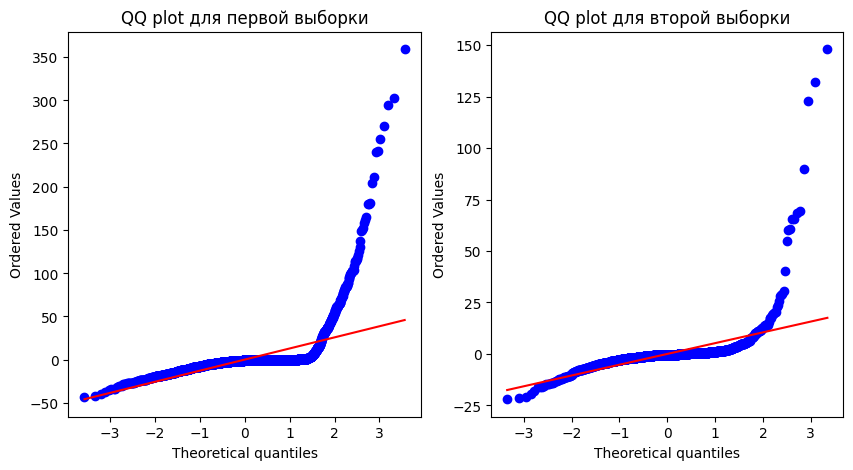

In [30]:
# Построение линейного графика
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
stats.probplot(combined_more20['deviation'], dist="norm", plot=plt)
plt.title('QQ plot для первой выборки')

plt.subplot(1, 2, 2)
stats.probplot(combined_less20['deviation'], dist="norm", plot=plt)
plt.title('QQ plot для второй выборки')

plt.show()

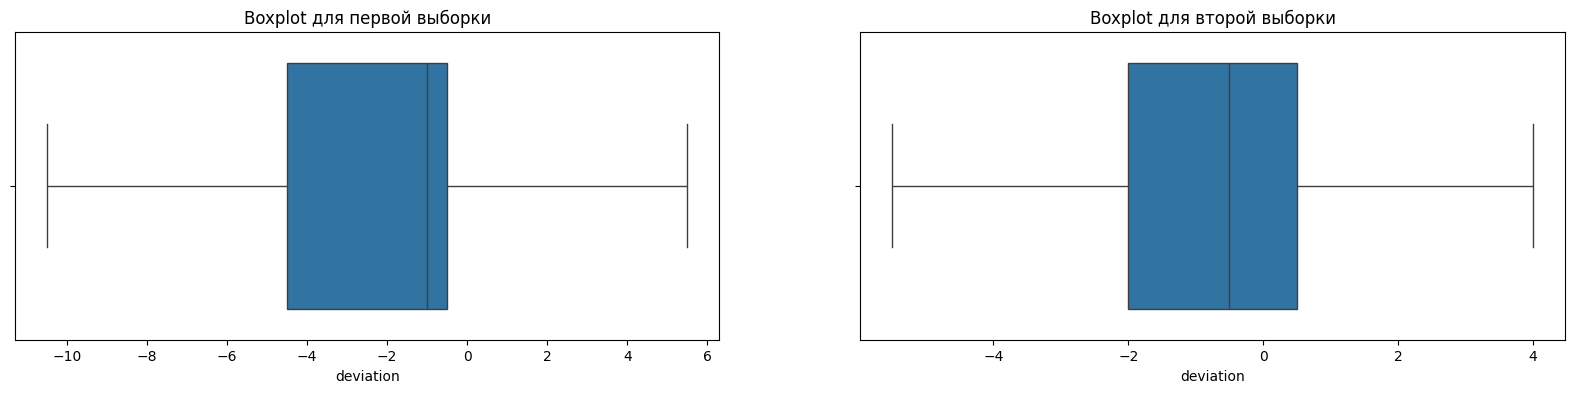

In [31]:
# Построение графика боксплот

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='deviation', data=combined_more20, ax=ax1, showfliers=False)
ax1.set_title('Boxplot для первой выборки')
sns.boxplot(x='deviation', data=combined_less20, ax=ax2, showfliers=False)
ax2.set_title('Boxplot для второй выборки')

plt.show()

In [32]:
# тест на нормальность
# Создаем функцию для определения нормальности распределния данных на основе теста Шапиро-Уилка
# Функция прининимает на вход датафрейм, столбец и значение альфа, которое по дефолту равно 0.05

def shapiro_test_function(dataframe, col, alpha=0.05):
    H_0 = 'Данные распределены нормально'
    H_1 = 'Данные распределены не нормально'
    _, p = shapiro(dataframe[col])
    print(f'alpha = {alpha}')
    print('p=%.5f' % p)
    if p > alpha:
        print(H_0)
    else:
        print(f'Мы отвергаем нулевую гипотезу.{H_1}')

In [33]:
shapiro_test_function(combined_more20, 'deviation')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


In [34]:
shapiro_test_function(combined_less20, 'deviation')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


Тест подтверждает, что данные в обеих выборках распределены не нормально

Для проведения статистичского теста выбираем непараметрический тест Манна-Уитни, так как данные распределеные ненормально (тест Шапиро-Уилка) и две выборки по сути являются независимыми (нет пересекающихся игроков).

[Тест Манна-Уитни](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html). 

Тест применяется для оценки различий между двумя независимыми группами, подходит для использования с данными, которые не являются нормально распределенными, и когда данные являются порядковыми (ранговыми) или по крайней мере могут быть упорядочены.

In [35]:
# тест Манна-Уитни на определение статистической значимости
# Создаем функцию на основе теста  Манна-Уитни
# Функция прининимает на вход два датафрейма, столбец, значение альфа, которое по дефолту равно 0.05 и вид параметра alternative
# парамтер alternative в тесте Манна-Уитни может принимать следующие значения: 'two-sided' (по дефолту), 'less', 'greater'

def mannwhitneyu_function(dataframe_1, dataframe_2, col, alpha=0.05, alternative_hyp='two-sided'):
    _, p_value = mannwhitneyu(
        dataframe_1[col], dataframe_2[col], alternative=alternative_hyp)
    print(f'alpha = {alpha}')
    print(f'alternative = {alternative_hyp}')
    print('p-value =', round(p_value, 5))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу.")
        print(f'Альтернативная гипотеза. H1: {H1}')
    else:
        print(f'Принимаем нулевую гипотезу. {H0}')

In [36]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Средние отклонения в двух выборках равны '
H1 = 'Среднее отклонение в выборке с различием в ранге больше 20 значимо больше'

# односторонняя гипотеза: 0.05/2=0.025
alpha = 0.025

mannwhitneyu_function(combined_more20, combined_less20,
                      'deviation', alpha, alternative_hyp='greater')

alpha = 0.025
alternative = greater
p-value = 1.0
Принимаем нулевую гипотезу. Средние отклонения в двух выборках равны 


Таким образом, по результатам статистического теста мы установили, что игроки с разностью в ранге более 20 выигрывают статистически также часто, как и игроки с меньшей разностью в ранге. Разница в рейтинге игроков не влияет на победу. 

б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

In [37]:
# оставляем турниры только с 1980 по 2022 год
filtered_df1 = df_1[(df_1['tourney_year'] >= 1980) &
                    (df_1['tourney_year'] <= 2022)]

In [38]:
# Создем выборки с различиями в рангах менее 5 и более 20 и создаем соответствующие датасеты.
less5 = filtered_df1[abs(filtered_df1['winner_rank'] -
                         filtered_df1['loser_rank']) < 6]
more20 = filtered_df1[abs(filtered_df1['winner_rank'] -
                          filtered_df1['loser_rank']) > 20]

# оставляем только необходимые столбцы
less5 = less5[['tourney_year', 'winner_id', 'loser_id']]
more20 = more20[['tourney_year', 'winner_id', 'loser_id',]]

In [39]:
more20.head()

,tourney_year,winner_id,loser_id
46769,1980,100297,100199
46772,1980,100434,100367
46796,1980,100434,100536
46797,1980,100383,100185
46860,1980,100091,100515


In [40]:
# Группировка по году и id с подсчетом количества побед для каждого игрока
sample_less5 = less5.groupby(['winner_id', 'tourney_year']).agg(
    count_winner=('winner_id', 'size')).reset_index()
sample_more20 = more20.groupby(['winner_id', 'tourney_year']).agg(
    count_winner=('winner_id', 'size')).reset_index()

In [41]:
sample_less5.head(3)

,winner_id,tourney_year,count_winner
0,100060,1980,1
1,100091,1980,2
2,100119,1981,1


In [42]:
# Группировка по году и c подсчетом среднего количества побед за каждый год
sample_less5_mean = sample_less5.groupby('tourney_year').agg(
    count_winner=('count_winner', 'mean')).reset_index()
sample_more20_mean = sample_more20.groupby('tourney_year').agg(
    count_winner=('count_winner', 'mean')).reset_index()

In [43]:
sample_more20_mean.head(5)

,tourney_year,count_winner
0,1980,9.043103
1,1981,9.091743
2,1982,8.050000
3,1983,6.734375
4,1984,7.931452


In [44]:
# Среднее значение побед в каждой выборке
print(
    f'Среднее значение побед в первой выборке:{round(sample_less5_mean["count_winner"].mean(), 3)}')
print(
    f'Среднее значение побед во второй выборке:{round(sample_more20_mean["count_winner"].mean(),3)}')

Среднее значение побед в первой выборке:2.305
Среднее значение побед во второй выборке:8.432


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


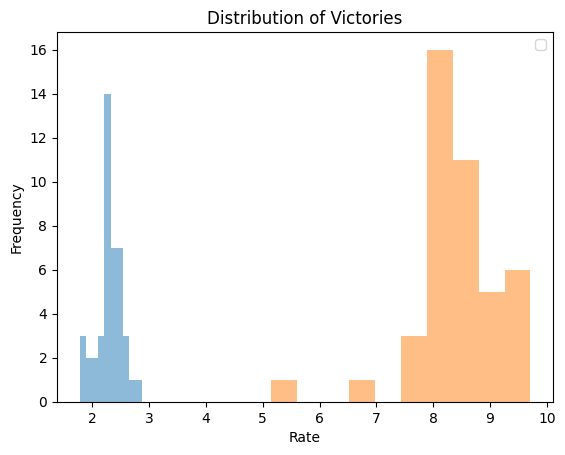

In [45]:
# Построение гистограммы
plt.hist(sample_less5_mean['count_winner'], bins=10, alpha=0.5)
plt.hist(sample_more20_mean['count_winner'], bins=10, alpha=0.5)

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Victories')
plt.legend()

plt.show()

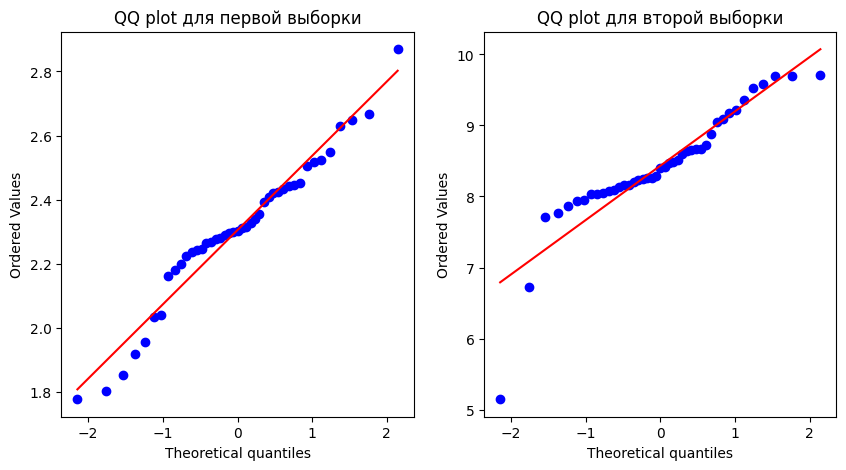

In [46]:
# Построение линейного графика
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
stats.probplot(sample_less5_mean['count_winner'], dist="norm", plot=plt)
plt.title('QQ plot для первой выборки')

plt.subplot(1, 2, 2)
stats.probplot(sample_more20_mean['count_winner'], dist="norm", plot=plt)
plt.title('QQ plot для второй выборки')

plt.show()

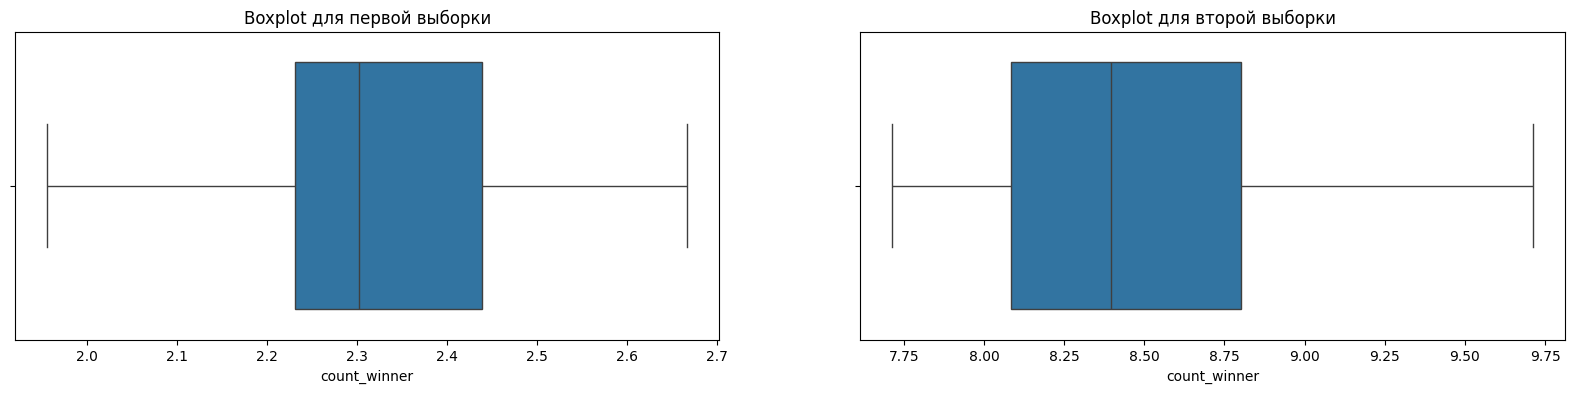

In [47]:
# Построение графика боксплот

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='count_winner', data=sample_less5_mean,
            ax=ax1, showfliers=False)
ax1.set_title('Boxplot для первой выборки')
sns.boxplot(x='count_winner', data=sample_more20_mean,
            ax=ax2, showfliers=False)
ax2.set_title('Boxplot для второй выборки')

plt.show()

Проводим статистический тест на нормальность

In [48]:
shapiro_test_function(sample_less5_mean, 'count_winner')

alpha = 0.05
p=0.18761
Данные распределены нормально


In [49]:
shapiro_test_function(sample_more20_mean, 'count_winner')

alpha = 0.05
p=0.00013
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


Так как в одной из групп данные распределены не нормально по результату теста Шапиро-Уилка, необходимо далее подобрать непараметрический тест, например, [тест Манна-Уитни](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html). 

Тест применяется для оценки различий между двумя независимыми группами, подходит для использования с данными, которые не являются нормально распределенными, и когда данные являются порядковыми (ранговыми) или по крайней мере могут быть упорядочены.

In [50]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Среднее количество побед равны в двух выборках'
H1 = 'Среднее количество побед в выборке c разницей в ранге более 20 больше, чем в другой выборке'

# односторонний тест alpha = 0.05/2 = 0.025
alpha = 0.025

mannwhitneyu_function(sample_more20_mean, sample_less5_mean,
                      'count_winner', alpha, alternative_hyp='greater')

alpha = 0.025
alternative = greater
p-value = 0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Среднее количество побед в выборке c разницей в ранге более 20 больше, чем в другой выборке


Вывод: Среднее количество побед статистически значимо больше в выборке с разницей в ранге более 20, чем в выборке с разницей в ранге менее 5. Таким образом, разница в ранге имеет значение в вероятности победы. 

## Задача 2

Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем?

Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

In [51]:
# Формируем выборки по годам: первая с 1980 до 2001 гг. и вторая с 2002 до 2022 гг.
sample1980_2001 = df_1[(df_1['tourney_year'] > 1979) &
                       (df_1['tourney_year'] < 2002)]
sample2002_2022 = df_1[(df_1['tourney_year'] > 2001) &
                       (df_1['tourney_year'] < 2023)]

In [52]:
# Оставляем только нужные столбцы для работы
sample1980_2001 = sample1980_2001[[
    'tourney_year', 'winner_id', 'winner_name', 'score']]
sample2002_2022 = sample2002_2022[[
    'tourney_year', 'winner_id', 'winner_name', 'score']]

In [53]:
# Функция для подсчёта количества сетов через регулярное выражение
def count_sets(score):
    return len(re.findall(r'\d+-\d+', str(score)))


# Применяем функцию к столбцу 'score' и создаём новый 'set_count'
sample1980_2001['set_count'] = sample1980_2001['score'].apply(count_sets)
sample2002_2022['set_count'] = sample2002_2022['score'].apply(count_sets)

In [54]:
sample1980_2001.sample(3)

,tourney_year,winner_id,winner_name,score,set_count
70821,1986,100855,Scott Davis,6-3 6-4,2
64321,1984,100656,Ivan Lendl,6-4 6-2,2
80606,1989,101012,Massimiliano Narducci,6-3 4-6 6-2,3


In [55]:
# Проверка пропусков
sample1980_2001.isna().sum()

tourney_year    0
winner_id       0
winner_name     0
score           3
set_count       0
dtype: int64

In [56]:
# Проверка пропусков
sample2002_2022.isna().sum()

tourney_year    0
winner_id       0
winner_name     0
score           0
set_count       0
dtype: int64

In [57]:
# Удаление пропусков
sample1980_2001 = sample1980_2001.dropna(subset=['score'])
sample1980_2001.isna().sum()

tourney_year    0
winner_id       0
winner_name     0
score           0
set_count       0
dtype: int64

In [58]:
# Среднее значение побед в каждой выборке
print(
    f'Среднее количество сетов для побед в первой выборке:{round(sample1980_2001["set_count"].mean(), 3)}')
print(
    f'Среднее количество сетов для побед во второй выборке:{round(sample2002_2022["set_count"].mean(),3)}')

Среднее количество сетов для побед в первой выборке:2.594
Среднее количество сетов для побед во второй выборке:2.62


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


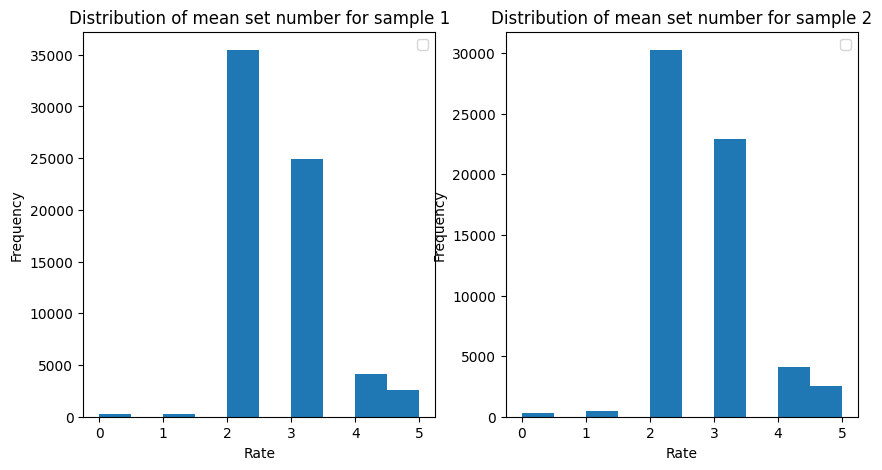

In [59]:
# Построение гистограммы

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(sample1980_2001['set_count'], bins=10)
plt.title('Distribution of mean set number for sample 1')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sample2002_2022['set_count'], bins=10)
plt.title('Distribution of mean set number for sample 2')

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()

plt.show()

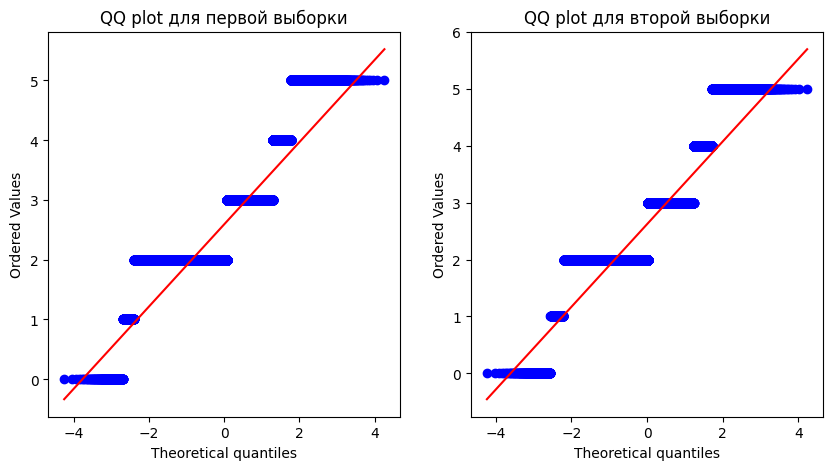

In [60]:
# Построение QQ plot графика
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
stats.probplot(sample1980_2001['set_count'], dist="norm", plot=plt)
plt.title('QQ plot для первой выборки')

plt.subplot(1, 2, 2)
stats.probplot(sample2002_2022['set_count'], dist="norm", plot=plt)
plt.title('QQ plot для второй выборки')

plt.show()

In [61]:
# Проверка распределения на нормальность с помощью теста Шапиро-Уилка
shapiro_test_function(sample1980_2001, 'set_count')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [62]:
shapiro_test_function(sample1980_2001, 'set_count')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


Так как в обеих группах данные распределены не нормально по результату теста Шапиро-Уилка и данные являются по сути независимыми (независимые выборки), необходимо далее подобрать непараметрический тест, например, [тест Манна-Уитни](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html). 

Тест применяется для оценки различий между двумя независимыми группами, подходит для использования с данными, которые не являются нормально распределенными, и когда данные являются порядковыми (ранговыми) или по крайней мере могут быть упорядочены.

In [63]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Среднее количество сетов, необходимое игроку для победы, равно в двух выборках'
H1 = 'Среднее количество сетов, необходимое игроку для победы, не равно в двух выборках'

# двусторонний тест
alpha = 0.05

mannwhitneyu_function(sample1980_2001, sample2002_2022, 'set_count', alpha)

alpha = 0.05
alternative = two-sided
p-value = 0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Среднее количество сетов, необходимое игроку для победы, не равно в двух выборках


Так как мы получили, что среднее количество сетов, необходимое игроку для победы, не равно в двух выборках, то необходимо дальше провести односторонний тест для уточнения, в какой выборке больше среднее количество сетов для победы.

In [64]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Среднее количество сетов, необходимое игроку для победы, равно в двух выборках'
H1 = 'Среднее количество сетов, необходимое игроку для победы, во второй выборке больше'

# односторонний тест
alpha = 0.025

mannwhitneyu_function(sample2002_2022, sample1980_2001,
                      'set_count', alpha, alternative_hyp='greater')

alpha = 0.025
alternative = greater
p-value = 0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Среднее количество сетов, необходимое игроку для победы, во второй выборке больше


Таким образом, по результатам статистического теста мы выяснили, что среднее количество сетов статистически значимо выше в выборке за период 2002-2022 по сравнению с выборкой за период 1980-2001.
Таким образом, среднее количество сетов для победы выросло со временем.

# Задание 3

У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным.

Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

In [65]:
# выбираем только best of 5 матчи
df_best_5 = df_1[df_1['best_of'] == 5]

In [66]:
# Ниже код скопирован из предыдущей задачи

# Формируем выборки по годам: первая с 1980 до 2001 гг. и вторая с 2002 до 2022 гг.
sample1980_2001 = df_best_5[(df_best_5['tourney_year'] > 1979) & (
    df_best_5['tourney_year'] < 2002)]
sample2002_2022 = df_best_5[(df_best_5['tourney_year'] > 2001) & (
    df_best_5['tourney_year'] < 2023)]

# Оставляем только нужные столбцы для работы
sample1980_2001 = sample1980_2001[[
    'tourney_year', 'winner_id', 'winner_name', 'score']]
sample2002_2022 = sample2002_2022[[
    'tourney_year', 'winner_id', 'winner_name', 'score']]

# Функция для подсчёта количества сетов через регулярное выражение


def count_sets(score):
    return len(re.findall(r'\d+-\d+', str(score)))


# Удаление пропусков
sample1980_2001 = sample1980_2001.dropna(subset=['score'])

# Применяем функцию к столбцу 'score' и создаём новый 'set_count'
sample1980_2001['set_count'] = sample1980_2001['score'].apply(count_sets)
sample2002_2022['set_count'] = sample2002_2022['score'].apply(count_sets)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


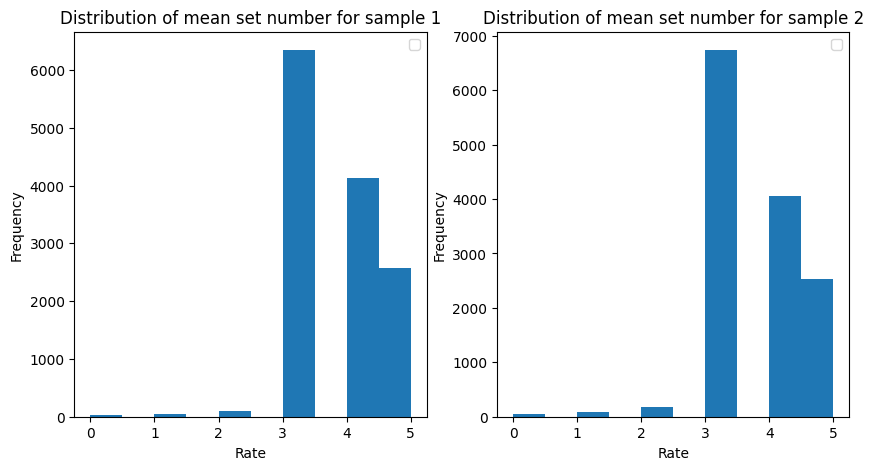

In [67]:
# Построение гистограммы
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(sample1980_2001['set_count'], bins=10)
plt.title('Distribution of mean set number for sample 1')
plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sample2002_2022['set_count'], bins=10)
plt.title('Distribution of mean set number for sample 2')

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [68]:
# Проверка распределения на нормальность с помощью теста Шапиро-Уилка
shapiro_test_function(sample1980_2001, 'set_count')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


c:\Users\Екатерина\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [69]:
shapiro_test_function(sample2002_2022, 'set_count')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


Так как в обеих группах данные распределены не нормально по результату теста Шапиро-Уилка и данные являются по сути независимыми (независимые выборки), необходимо далее подобрать непараметрический тест, например, [тест Манна-Уитни](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html). 

Тест применяется для оценки различий между двумя независимыми группами, подходит для использования с данными, которые не являются нормально распределенными, и когда данные являются порядковыми (ранговыми) или по крайней мере могут быть упорядочены.

In [70]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Среднее количество сетов, необходимое игроку для победы, равно в двух выборках'
H1 = 'Среднее количество сетов, необходимое игроку для победы, не равно в двух выборках'

# двусторонний тест
alpha = 0.05

mannwhitneyu_function(sample1980_2001, sample2002_2022,
                      'set_count', alpha, alternative_hyp='two-sided')

alpha = 0.05
alternative = two-sided
p-value = 1e-05
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Среднее количество сетов, необходимое игроку для победы, не равно в двух выборках


Так как мы получили, что среднее количество сетов, необходимое игроку для победы, не равно в двух выборках, то необходимо дальше провести односторонний тест для уточнения, в какой выборке больше среднее количество сетов для победы.

In [71]:
# Формулирование гипотез: нулевая и альтернативная
H0 = 'Среднее количество сетов, необходимое игроку для победы, равно в двух выборках'
H1 = 'Среднее количество сетов, необходимое игроку для победы, в первой выборке больше'

# односторонний тест
alpha = 0.025

mannwhitneyu_function(sample1980_2001, sample2002_2022,
                      'set_count', alpha, alternative_hyp='greater')

alpha = 0.025
alternative = greater
p-value = 1e-05
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Среднее количество сетов, необходимое игроку для победы, в первой выборке больше


Таким образом, по результатам статистического теста мы выяснили, что для матчей категории best of 5 среднее количество сетов, которые сыграли победители, статистически значимо больше в выборке за период 1980-2001 по сравнению с выборкой за период 2002-2022. Таким образом, для матчей этой категории среднее количество сетов для победы уменьшилось. 

# Задание 4

Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис.

Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

In [72]:
# копируем датасет
df2 = df_1.copy()

In [73]:
# Группируем исходный датафрейм по winner_name и агрегируем годы tourney_year
grouped = df2.groupby('winner_name')['tourney_year'].agg(
    lambda x: list(sorted(set(x))))

# Фильтруем тех игроков, которые играли более 10 лет подряд


def filter_consecutive_years(years_list):
    # Убедимся, что года идут по порядку без повторений
    years_list = sorted(set(years_list))
    for start in range(len(years_list) - 10):  # Проверка подряд идущих лет
        if years_list[start + 10] - years_list[start] == 10:
            return True
    return False


# Теперь применяем функцию фильтрации к нашей группировке
consistent_players = grouped[grouped.apply(filter_consecutive_years)].index

# Создание нового датафрейма new_df с нужными столбцами и отфильтрованными игроками:

# Сначала получаем все колонки, которые заканчиваются на bpFaced и bpSaved
bp_columns = [col for col in df2.columns if col.endswith(
    'bpFaced') or col.endswith('bpSaved')]

# Список колонок, которые нам нужны в new_df
columns_needed = ['tourney_year', 'tourney_id', 'winner_id', 'winner_name',
                  'winner_rank', 'loser_id', 'loser_name', 'loser_rank'] + bp_columns

# Фильтруем исходный датафрейм, чтобы включить только тех игроков, которые есть в consistent_players
filtered_df2 = df2[df2['winner_name'].isin(consistent_players)]

# Создаем new_df с нужными колонками
new_df = filtered_df2[columns_needed].drop_duplicates()

In [74]:
new_df.head(3)

,tourney_year,tourney_id,winner_id,winner_name,winner_rank,loser_id,loser_name,loser_rank,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced
18086,1973,1973-2016,100119,Ilie Nastase,1.0,100129,Jean Baptiste Chanfreau,88.0,NaN,NaN,NaN,NaN
18090,1973,1973-2016,100284,Jimmy Connors,4.0,100058,Roger Taylor,11.0,NaN,NaN,NaN,NaN
18102,1973,1973-2016,100119,Ilie Nastase,1.0,100304,Robert Kreiss,193.0,NaN,NaN,NaN,NaN


In [75]:
# первые 10 игроков нового датасета
new_df['winner_name'].value_counts().head(10)

winner_name
Roger Federer     1262
Novak Djokovic    1098
Rafael Nadal      1079
Ivan Lendl         949
Jimmy Connors      878
Andre Agassi       867
Stefan Edberg      796
Pete Sampras       758
John McEnroe       744
Andy Murray        739
Name: count, dtype: int64

In [76]:
# Создание датафрейма с выбранными именами в победных матчах
# Расчет доли выигранных брейк-поинтов для победителя
win_df = new_df[new_df['winner_name'].isin(
    ["Roger Federer", "Novak Djokovic", "Rafael Nadal"])]
win_df.drop(['loser_name', 'loser_id', 'l_bpSaved',
            'l_bpFaced', 'loser_rank'], axis=1, inplace=True)
win_df['w_bp_rate'] = win_df['w_bpSaved']/win_df['w_bpFaced']

# Создание датафрейма с выбранными именами в проигрышных матчах
# Расчет доли выигранных брейк-поинтов для проигравшего
lose_df = new_df[new_df['loser_name'].isin(
    ["Roger Federer", "Novak Djokovic", "Rafael Nadal"])]
lose_df.drop(['winner_name', 'winner_id', 'w_bpSaved',
             'w_bpFaced', 'winner_rank'], axis=1, inplace=True)
lose_df['l_bp_rate'] = lose_df['l_bpSaved']/lose_df['l_bpFaced']

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\1251385276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_df.drop(['loser_name', 'loser_id', 'l_bpSaved',
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\1251385276.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_df['w_bp_rate'] = win_df['w_bpSaved']/win_df['w_bpFaced']
C:\Users\Екатерина\AppData\Local\Temp\ipykernel_13368\1251385276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [77]:
win_df.sample(5)

,tourney_year,tourney_id,winner_id,winner_name,winner_rank,w_bpSaved,w_bpFaced,w_bp_rate
158528,2012,2012-451,104745,Rafael Nadal,2.0,2.0,4.0,0.500000
188714,2022,2022-0605,104745,Rafael Nadal,2.0,2.0,2.0,1.000000
182579,2020,2020-560,104925,Novak Djokovic,1.0,3.0,5.0,0.600000
160056,2012,2012-520,103819,Roger Federer,3.0,1.0,3.0,0.333333
146284,2008,2008-1720,104925,Novak Djokovic,3.0,4.0,5.0,0.800000


Text(0, 0.5, 'Количество матчей с победой')

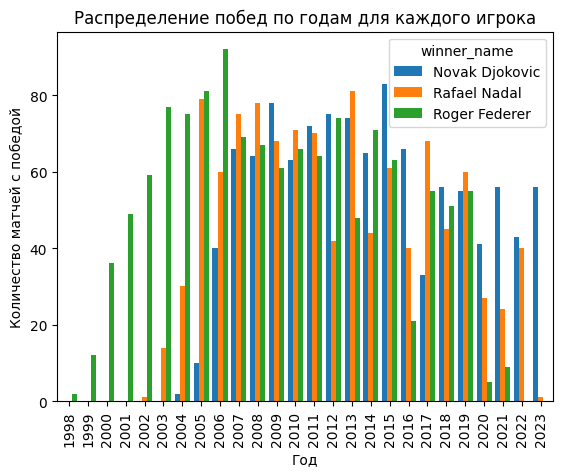

In [78]:
# Для поиска подходящего периода времени (10 лет) необходимо проследить, в какие годы играли выбранные игроки
# Для этого простроим график

win_plot = win_df.groupby(['tourney_year', 'winner_name']).size(
).unstack().plot(kind='bar', stacked=False, width=0.8)
win_plot.set_title('Распределение побед по годам для каждого игрока')
win_plot.set_xlabel('Год')
win_plot.set_ylabel('Количество матчей с победой')

Таким образом, выбраем период с 2006 по 2019 года, когда играли все 3 игрока 

In [79]:
# Преобразуем выборки для выбранного периода времени с 2006 по 2019г.

filtered_win_df = win_df[(win_df['tourney_year'] >= 2006)
                         & (win_df['tourney_year'] <= 2019)]
filtered_lose_df = lose_df[(lose_df['tourney_year'] >= 2006) & (
    lose_df['tourney_year'] <= 2019)]

In [80]:
# Создаем датасет для игрока Рафаэль Надаль и его долями выигранных брейк-поинтов

rafael_nadal_wins = filtered_win_df[(filtered_win_df['winner_name'] == 'Rafael Nadal')][[
    'tourney_id', 'tourney_year', 'w_bp_rate']]
rafael_nadal_losses = filtered_lose_df[(
    filtered_lose_df['loser_name'] == 'Rafael Nadal')][['tourney_id', 'l_bp_rate']]
rafael_nadal_df = rafael_nadal_wins.merge(rafael_nadal_losses, on='tourney_id')
rafael_nadal_df = rafael_nadal_df.dropna(subset=['w_bp_rate', 'l_bp_rate'])

rafael_nadal_df.head(3)

,tourney_id,tourney_year,w_bp_rate,l_bp_rate
0,2006-1536,2006,1.0,0.000000
1,2006-1536,2006,1.0,0.000000
2,2006-311,2006,1.0,0.846154


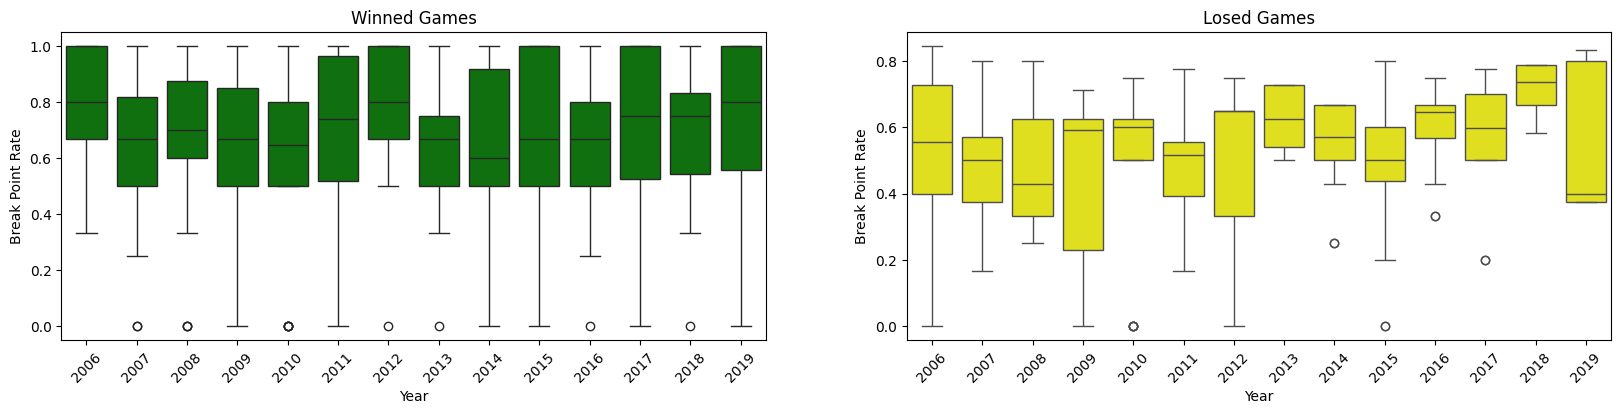

In [81]:
# Боксплот для игрока Рафаэль Надаль за выигрышные матчи и пригрышные

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='tourney_year', y='w_bp_rate',
            data=rafael_nadal_df, color='green', ax=ax1)
sns.boxplot(x='tourney_year', y='l_bp_rate',
            data=rafael_nadal_df, color='yellow', ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Break Point Rate')
ax1.set_title('Winned Games')
ax1.tick_params(axis='x', rotation=45)

ax2.set_xlabel('Year')
ax2.set_ylabel('Break Point Rate')
ax2.set_title('Losed Games')
ax2.tick_params(axis='x', rotation=45)


plt.show()

In [82]:
# Создаем датасет для игрока Новак Джокович и его долями выигранных брейк-поинтов

Djokovic_wins = filtered_win_df[(filtered_win_df['winner_name'] == 'Novak Djokovic')][[
    'tourney_id', 'tourney_year', 'w_bp_rate']]
Djokovic_losses = filtered_lose_df[(
    filtered_lose_df['loser_name'] == 'Novak Djokovic')][['tourney_id', 'l_bp_rate']]
Djokovic_df = Djokovic_wins.merge(Djokovic_losses, on='tourney_id')
Djokovic_df = Djokovic_df.dropna(subset=['w_bp_rate', 'l_bp_rate'])

Djokovic_df.head(3)

,tourney_id,tourney_year,w_bp_rate,l_bp_rate
0,2006-1536,2006,0.500000,0.636364
1,2006-1536,2006,0.571429,0.636364
2,2006-2276,2006,0.714286,0.800000


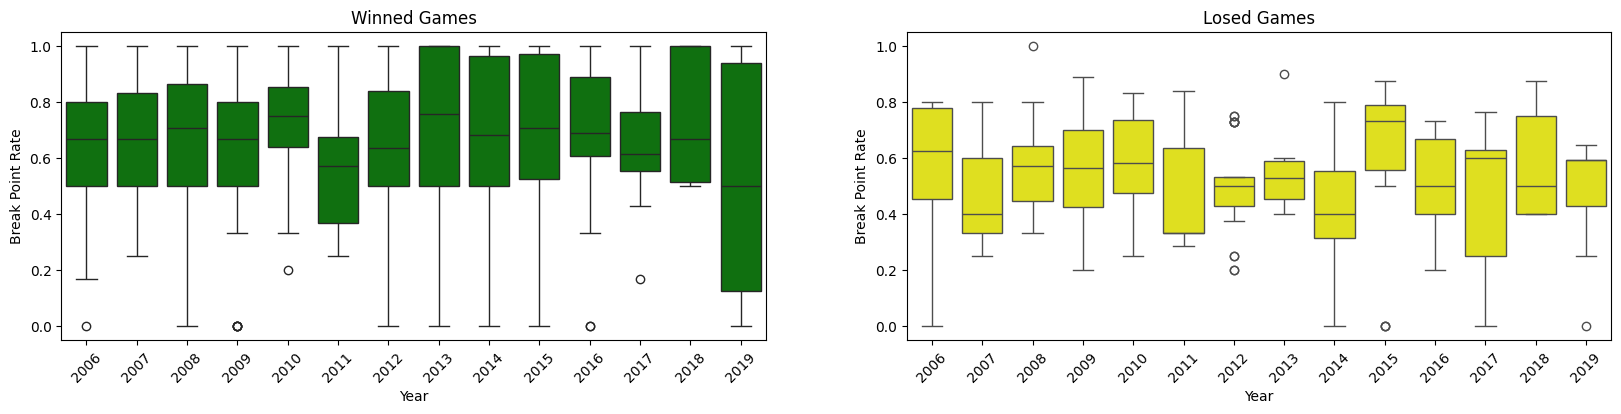

In [83]:
# Боксплот для игрока Новак Джокович за выигрышные матчи и пригрышные

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='tourney_year', y='w_bp_rate',
            data=Djokovic_df, color='green', ax=ax1)
sns.boxplot(x='tourney_year', y='l_bp_rate',
            data=Djokovic_df, color='yellow', ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Break Point Rate')
ax1.set_title('Winned Games')
ax1.tick_params(axis='x', rotation=45)

ax2.set_xlabel('Year')
ax2.set_ylabel('Break Point Rate')
ax2.set_title('Losed Games')
ax2.tick_params(axis='x', rotation=45)


plt.show()

In [84]:
# Создаем датасет для игрока Роджер Федерер и его долями выигранных брейк-поинтов

Federer_wins = filtered_win_df[(filtered_win_df['winner_name'] == 'Roger Federer')][[
    'tourney_id', 'tourney_year', 'w_bp_rate']]
Federer_losses = filtered_lose_df[(
    filtered_lose_df['loser_name'] == 'Roger Federer')][['tourney_id', 'l_bp_rate']]
Federer_df = Federer_wins.merge(Federer_losses, on='tourney_id')
Federer_df = Federer_df.dropna(subset=['w_bp_rate', 'l_bp_rate'])

Federer_df.head(3)

,tourney_id,tourney_year,w_bp_rate,l_bp_rate
0,2006-410,2006,0.0,0.5
2,2006-410,2006,1.0,0.5
3,2006-410,2006,0.8,0.5


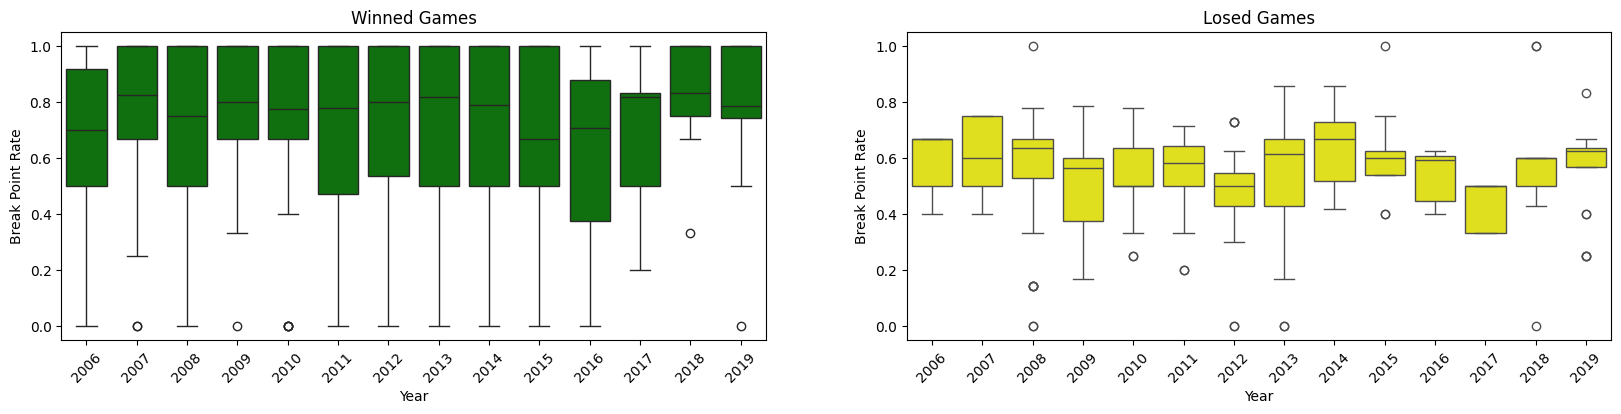

In [85]:
# Боксплот для игрока Роджер Федерер за выигрышные матчи и пригрышные

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
sns.boxplot(x='tourney_year', y='w_bp_rate',
            data=Federer_df, color='green', ax=ax1)
sns.boxplot(x='tourney_year', y='l_bp_rate',
            data=Federer_df, color='yellow', ax=ax2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Break Point Rate')
ax1.set_title('Winned Games')
ax1.tick_params(axis='x', rotation=45)

ax2.set_xlabel('Year')
ax2.set_ylabel('Break Point Rate')
ax2.set_title('Losed Games')
ax2.tick_params(axis='x', rotation=45)


plt.show()

In [86]:
# Проверка распределения на нормальность с помощью теста Шапиро-Уилка игрока Roger Federer
shapiro_test_function(Federer_df, 'w_bp_rate')
shapiro_test_function(Federer_df, 'l_bp_rate')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально
alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


In [87]:
# Проверка распределения на нормальность с помощью теста Шапиро-Уилка игрока Novak Djokovic
shapiro_test_function(Djokovic_df, 'w_bp_rate')
shapiro_test_function(Djokovic_df, 'l_bp_rate')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально
alpha = 0.05
p=0.00009
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


In [88]:
# Проверка распределения на нормальность с помощью теста Шапиро-Уилка игрока Rafael Nadal
shapiro_test_function(rafael_nadal_df, 'w_bp_rate')
shapiro_test_function(rafael_nadal_df, 'l_bp_rate')

alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально
alpha = 0.05
p=0.00000
Мы отвергаем нулевую гипотезу.Данные распределены не нормально


Размер выборок

In [89]:
print(f'Размер первой выборки: {rafael_nadal_df.shape}')
print(f'Размер первой выборки: {Federer_df.shape}')
print(f'Размер первой выборки: {Djokovic_df.shape}')

Размер первой выборки: (341, 4)
Размер первой выборки: (348, 4)
Размер первой выборки: (353, 4)


Вывод: по результатам теста Шапиро-Уилка все данные распределены не нормально. 

Для определения статистической рзницы далее необходимо выбрать соответствующий тест на основе следующих данных:
 - данные распределены не нормально по результатам теста Шапиро-Уилка --> непараметрический тест
 - объем данных более 340 в каждом датасете
 - необходимо выбрать тест для внутригруппового анализа - выяснить, является ли распределение по годам по 2 параметрам зависимым для каждого игрока. 
 - необходимо выбрать тест для попарного сравнения всех трех игроков по среднему значению изучаемых параметров

Вопрос из задания: Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? 

В данном случае может подойти [тест Фридмана](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html) , который предназначен для анализа различий в распределениях между парными или связанными выборками с ненормальным распределением. Он является непараметрическим аналогом однофакторного дисперсионного анализа для повторных измерений.

Нулевая гипотеза (H0) для теста Фридмана заключается в том, что медианные значения w_bp_rate и l_bp_rate одинаковы во всех годах (то есть, распределение данных по годам независимо). Альтернативная гипотеза (H1) заключается в том, что по крайней мере в одном году медианные значения параметров отличаются от медианных значений хотя бы в одном другом году (то есть, существует зависимость распределения данных от года).

In [90]:
# Подготовка датасета для проведения теста Фридмана
# Она необходима, так как количетсво наблюдений за каждый год у нас отличается (в 2-3 раза)
# Для того, чтобы не удалять данные мы будем рассчитывать медиану в тех строках, где данных больше

# Функция принимает на вход датафрейм и на выходе выдает обработанный датафрейм с таким же названием.
def balance_function(df):

    # Шаг 1: Группировка по году и подсчет количества наблюдений
    counts_per_year = df.groupby(
        'tourney_year').size().reset_index(name='count')

    # Шаг 2: Нахождение наименьшего количества наблюдений
    min_count = counts_per_year['count'].min()

    # Создаем новый DataFrame для сбалансированных данных
    balanced_df = pd.DataFrame()

    # Проходимся по каждому году
    for year in counts_per_year['tourney_year']:
        # Отфильтровываем данные за текущий год
        year_data = df[df['tourney_year'] == year]

        # Вычисляем коэффициент для объединения строк
        factor = len(year_data) / min_count

        # Создаем временный список для медиан
        medians = []

        # Объединяем соседние строки и вычисляем медиану
        for i in range(min_count):
            # Определяем индексы строк для объединения
            start_idx = int(i * factor)
            end_idx = int((i + 1) * factor)
            if i == min_count - 1:
                # Убедимся, что включаем все оставшиеся строки
                end_idx = len(year_data)

            # Получаем срез данных для группировки
            subset = year_data.iloc[start_idx:end_idx]

            # Вычисляем медиану только для числовых столбцов
            numeric_subset = subset.select_dtypes(include=[np.number])
            median_values = numeric_subset.median()
            # Добавляем год к медианным значениям
            median_values['tourney_year'] = year
            medians.append(median_values)

        # Создаем DataFrame из медиан и добавляем в сбалансированный DataFrame
        median_df = pd.DataFrame(medians)
        balanced_df = pd.concat([balanced_df, median_df], ignore_index=True)
    return balanced_df

In [91]:
# Проверка исходного датасета
test = Djokovic_df.groupby('tourney_year').agg(
    count=('w_bp_rate', 'count')).reset_index()
test.head(15)

,tourney_year,count
0,2006,21
1,2007,35
2,2008,38
3,2009,50
4,2010,40
5,2011,11
6,2012,35
7,2013,26
8,2014,22
9,2015,18


In [92]:
rafael_nadal_balanced = balance_function(rafael_nadal_df)
Djokovic_balanced = balance_function(Djokovic_df)
Federer_balanced = balance_function(Federer_df)

In [93]:
# Проверка датасета после сбалансирования
test = Djokovic_balanced.groupby('tourney_year').agg(
    count=('w_bp_rate', 'count')).reset_index()
test.head(15)

,tourney_year,count
0,2006.0,10
1,2007.0,10
2,2008.0,10
3,2009.0,10
4,2010.0,10
5,2011.0,10
6,2012.0,10
7,2013.0,10
8,2014.0,10
9,2015.0,10


In [94]:
# Функция для проведения теста Фридмана с группировкой данных по годам
# Функция на вход принимает датафрейм, значение альфа (по дефолту 0.05)

def fridman_function(df, alpha=0.05):
    # Группировка данных по годам и расчет медианных значений для каждого года
    grouped = df.groupby('tourney_year')

    # Списки для хранения медианных значений по каждому году
    w_bp_rate_by_year = []
    l_bp_rate_by_year = []

    for name, group in grouped:
        w_bp_rate_by_year.append(group['w_bp_rate'].tolist())
        l_bp_rate_by_year.append(group['l_bp_rate'].tolist())

    # Проведение теста Фридмана
    # Применение для w_bp_rate
    __, p_value = friedmanchisquare(*w_bp_rate_by_year)
    print(f'alpha = {alpha}')
    print(f'p-value: {round(p_value,5)}')

    # Интерпретация результатов
    if p_value > alpha:
        print('Нулевая гипотеза не отвергнута: распределения w_bp_rate независимы по годам')
    else:
        print('Нулевая гипотеза отвергнута: существует зависимость w_bp_rate от года')

    # Аналогично для l_bp_rate
    __, p_value = friedmanchisquare(*l_bp_rate_by_year)
    print(f'alpha = {alpha}')
    print(f'p-value: {round(p_value,5)}')

    if p_value > alpha:
        print('Нулевая гипотеза не отвергнута: распределения l_bp_rate независимы по годам')
    else:
        print('Нулевая гипотеза отвергнута: существует зависимость l_bp_rate от года')

In [95]:
print('Результаты теста для игрока Рафаэль Надаль')
fridman_function(rafael_nadal_balanced)

Результаты теста для игрока Рафаэль Надаль
alpha = 0.05
p-value: 0.5445
Нулевая гипотеза не отвергнута: распределения w_bp_rate независимы по годам
alpha = 0.05
p-value: 0.01347
Нулевая гипотеза отвергнута: существует зависимость l_bp_rate от года


In [96]:
print('Результаты теста для игрока Новак Джокович')
fridman_function(Djokovic_balanced)

Результаты теста для игрока Новак Джокович
alpha = 0.05
p-value: 0.81001
Нулевая гипотеза не отвергнута: распределения w_bp_rate независимы по годам
alpha = 0.05
p-value: 0.37977
Нулевая гипотеза не отвергнута: распределения l_bp_rate независимы по годам


In [97]:
print('Результаты теста для игрока Роджер Федерер')
fridman_function(Federer_balanced)

Результаты теста для игрока Роджер Федерер
alpha = 0.05
p-value: 0.83846
Нулевая гипотеза не отвергнута: распределения w_bp_rate независимы по годам
alpha = 0.05
p-value: 0.33301
Нулевая гипотеза не отвергнута: распределения l_bp_rate независимы по годам


Таким образом по результату теста Фримана была выявлена зависимость по годам у игрока Рафаэль Надаль: существует зависимость l_bp_rate (доля брейкпоинтов в проигрышных матчах) от года.

У остальных игроков зависимость не была установлена ни по одному изучаемому парамтеру.

Вопрос из задания:  Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками?

Для проведения статистического попарного сравнения между тремя игроками подходит **тест Краскела-Уоллиса**, который позволяет сравнивать медианы двух независимых выборок с ненормальным распределением. Тест позволит определить, есть ли статистически значимые различия между медианами выигрышных и проигрышных брейкпоинтов разных игроков. Теста Краскела-Уоллиса проверяет гипотезу о том, что медианы всех групп равны. Если тест показывает, что медианы не равны, это не указывает на то, какие именно группы различаются. Для определения различающихся групп необходим дополнительный пост-хок анализ с поправкой на множественное тестирование.

In [98]:
# Функция для проведения теста Краскела-Уоллиса
# Принимает на вход два сравниваемых датафрейма, столбец для сравнения, значение альфа (по дефолту - 0.05)

def kruskal_function(data_player1, data_player2, col, alpha=0.05):
    __, p = kruskal(data_player1[col], data_player2[col])
    alpha = alpha
    print(f'alpha = {alpha}')
    print('p-value =', round(p, 5))
    if (p < alpha):
        print("Отвергаем нулевую гипотезу.")
        print(f'Альтернативная гипотеза. H1: {H1}')
    else:
        print(f'Принимаем нулевую гипотезу. {H0}')

In [99]:
# тест Краскела-Уоллиса на определение статистической независимости игроков попарно
# Тест для игроков Р. Надаль и Р. Федерер

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(rafael_nadal_df, Federer_df, 'w_bp_rate')

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями l_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между средними показателями l_bp_rate и у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(rafael_nadal_df, Federer_df, 'l_bp_rate')

alpha = 0.05
p-value = 0.00884
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Есть значимая разница между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков не равны).
alpha = 0.05
p-value = 0.05316
Принимаем нулевую гипотезу. Нет значимой разницы между средними показателями l_bp_rate у двух выбранных игроков (Медианы двух игрков равны).


По результатам теста мы можем предположить, что между игроками Р. Надаль и Р. Федерер есть статистически значимая разница в средних показателях для выигранных матчей. 

In [100]:
# тест Краскела-Уоллиса на определение статистической независимости игроков попарно
# Тест для игроков Р. Надаль и Н. Джокович

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(rafael_nadal_df, Djokovic_df, 'w_bp_rate')

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями l_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между средними показателями l_bp_rate и у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(rafael_nadal_df, Djokovic_df, 'l_bp_rate')

alpha = 0.05
p-value = 0.34934
Принимаем нулевую гипотезу. Нет значимой разницы между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков равны).
alpha = 0.05
p-value = 0.80953
Принимаем нулевую гипотезу. Нет значимой разницы между средними показателями l_bp_rate у двух выбранных игроков (Медианы двух игрков равны).


По результатам теста между игроками Р. Надаль и Н. Джокович можно предположить, что разницы в средних показателях для выигранных и проигранных матчей нет. 

In [101]:
# тест Краскела-Уоллиса на определение статистической независимости игроков попарно
# Тест для игроков Н. Джокович и Р. Федерер

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(Djokovic_df, Federer_df, 'w_bp_rate')

# Формулирование гипотез для показателя w_bp_rate
H0 = 'Нет значимой разницы между средними показателями l_bp_rate у двух выбранных игроков (Медианы двух игрков равны).'
H1 = 'Есть значимая разница между  средними показателями l_bp_rate и у двух выбранных игроков (Медианы двух игрков не равны).'

kruskal_function(Djokovic_df, Federer_df, 'l_bp_rate')

alpha = 0.05
p-value = 0.00051
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Есть значимая разница между средними показателями w_bp_rate у двух выбранных игроков (Медианы двух игрков не равны).
alpha = 0.05
p-value = 0.01608
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Есть значимая разница между  средними показателями l_bp_rate и у двух выбранных игроков (Медианы двух игрков не равны).


По результатам теста мы можем предположить, что между игроками Н. Джокович и Р. Федерер есть статистически значимая разница в средних показателях для выигранных и проигранных матчей. 

# Задание 5

У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре.

Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

In [102]:
# копируем датасет
df3 = df_1.copy()

In [103]:
# Формирование выборки

# Выделяем необходимые столбцы
filter_df = df3[['tourney_id', 'tourney_year', 'winner_id', 'winner_name', 'loser_id',
                 'loser_name', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced']].dropna()

# Удаление дубликатов
filter_df = filter_df.drop_duplicates()

# Создание нового признака - доля выигранных и проигранных брейкпоинтов для каждого матча
filter_df['w_bp_ratio'] = filter_df['w_bpSaved'] / filter_df['w_bpFaced']
filter_df['l_bp_ratio'] = filter_df['l_bpSaved'] / filter_df['l_bpFaced']

In [104]:
filter_df.head(3)

,tourney_id,tourney_year,winner_id,winner_name,loser_id,loser_name,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced,w_bp_ratio,l_bp_ratio
86621,1991-339,1990,101723,Magnus Larsson,101414,Boris Becker,2.0,4.0,6.0,8.0,0.5,0.75
86622,1991-339,1990,100946,Slobodan Zivojinovic,101256,Mark Kratzmann,9.0,10.0,1.0,2.0,0.9,0.50
86623,1991-339,1990,101234,Patrik Kuhnen,101421,Veli Paloheimo,1.0,1.0,4.0,8.0,1.0,0.50


In [105]:
# Медиана для новых признаков
w_median_ratio = filter_df['w_bp_ratio'].median()
l_median_ratio = filter_df['l_bp_ratio'].median()

In [106]:
w_median_ratio

0.6666666666666666

In [107]:
# Разделение выигравших и проигравших
win = filter_df[['tourney_year', 'winner_id', 'w_bp_ratio']].rename(
    columns={'winner_id': 'id', 'w_bp_ratio': 'ratio'}).drop_duplicates()
lose = filter_df[['tourney_year', 'loser_id', 'l_bp_ratio']].rename(
    columns={'loser_id': 'id', 'l_bp_ratio': 'ratio'}).drop_duplicates()

# Для верификации победы или поражения добавляем столбец, где 1 - победа, 0 - проигрыш для игрока
win['result'] = 1
lose['result'] = 0

In [108]:
win.head(3)

,tourney_year,id,ratio,result
86621,1990,101723,0.5,1
86622,1990,100946,0.9,1
86623,1990,101234,1.0,1


In [109]:
# Далее создаем новый столбец, который будет содержать True, если значение ratio выше медианы,
# или False, если ниже медианы

win['mediana_level'] = win['ratio'] >= w_median_ratio
lose['mediana_level'] = lose['ratio'] >= l_median_ratio

In [110]:
# Объединение датасетов
combined_df3 = pd.concat([win, lose], ignore_index=True)
combined_df3.sample(5)

,tourney_year,id,ratio,result,mediana_level
3784,1992,100652,0.700000,1,True
116206,2021,105916,0.375000,0,False
22210,2003,104026,0.333333,1,False
26942,2006,102869,0.785714,1,True
22690,2003,102227,0.700000,1,True


In [111]:
# Группировка для визуализации
groupped_df3 = combined_df3.groupby(
    'result')['mediana_level'].value_counts().unstack().reset_index()
groupped_df3.head()

mediana_level,result,False,True
0,0,26790,43629
1,1,25159,26515


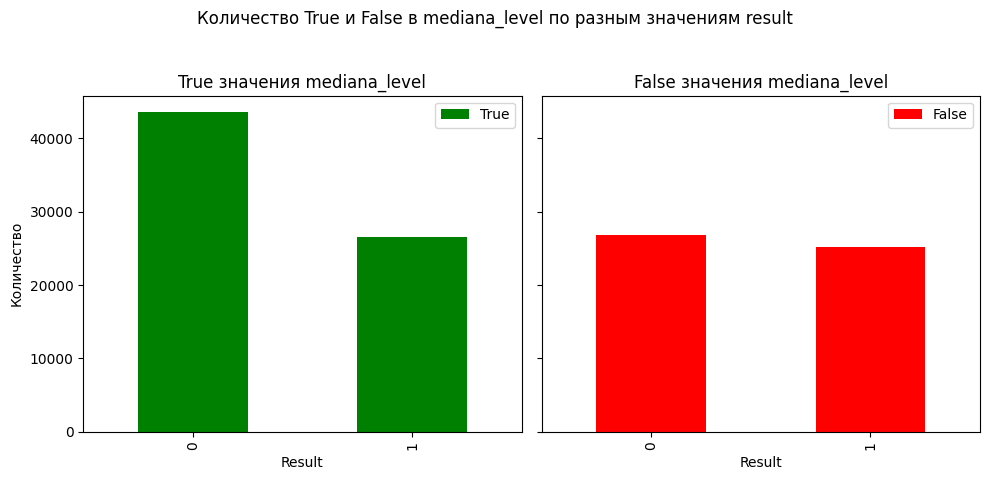

In [112]:
# Построение столбчатой диаграммы

# Построение отдельных столбчатых диаграмм для True и False
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

# Диаграмма для True значений
groupped_df3.plot(x='result', y=True, kind='bar', color='green', ax=axes[0])
axes[0].set_title('True значения mediana_level')
axes[0].set_xlabel('Result')
axes[0].set_ylabel('Количество')
axes[0].legend(['True'])

# Диаграмма для False значений
groupped_df3.plot(x='result', y=False, kind='bar', color='red', ax=axes[1])
axes[1].set_title('False значения mediana_level')
axes[1].set_xlabel('Result')
axes[1].legend(['False'])

plt.suptitle(
    'Количество True и False в mediana_level по разным значениям result')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Для выбора статистического теста нужно учитывать следующее:
 - переменные парные, бинарные, категориальные
 - выборка большая (более 25 тысяч наблюдений в каждой категории), что позволяет использовать приближение хи-квадрат.
 - выборки связаны, так как данные о проигрышах и выигрышах брались из одной строки 

Для проверки зависимости между победой в матче (бинарный признак) и превышением уровня медианы (также бинарный признак) можно использовать тест хи-квадрат (Chi-squared test) на независимость. Этот тест оценивает, есть ли значимая статистическая связь между двумя категориальными переменными в таблице сопряженности.


**Нулевая гипотеза (H0):** Нет связи между победой в матче и тем, выше или ниже медианы уровень ratio. То есть, превышение или непревышение медианы не влияет на результат матча.
**Альтернативная гипотеза (H1):** Существует связь между победой в матче и уровнем ratio относительно медианы. То есть, результат матча зависит от того, был ли уровень ratio выше или ниже медианы.

In [113]:
# Создаем кросс-таблицу для этих столбцов
crosstab = pd.crosstab(combined_df3['result'], combined_df3['mediana_level'])

In [114]:
crosstab

mediana_level,False,True
result,,
0,26790,43629
1,25159,26515


In [115]:
# Формулирование гипотезы

H0: 'Нет связи между победой в матче и значение выигранных брейкпоинтов по отношению к медиане.'
H1 = 'Существует связь между победой в матче и значение выигранных брейкпоинтов по отношению к медиане'

alpha = 0.005

# Выполнение теста хи-квадрат
__, p, __, __ = chi2_contingency(crosstab)
print(f"P-value: {round(p,5)}")
print(f"alpha: {alpha}")

if (p < alpha):
    print("Отвергаем нулевую гипотезу.")
    print(f'Альтернативная гипотеза. H1: {H1}')
else:
    print(f'Принимаем нулевую гипотезу. {H0}')

P-value: 0.0
alpha: 0.005
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Существует связь между победой в матче и значение выигранных брейкпоинтов по отношению к медиане


p-value имеет очень маленькое значение близкое к 0, поэтому оно меньше, чем установленный уровень значимости alpha (0.05). Соответственно, мы отвергаем нулевую гипотезу Н0 и принимаем альтернативную Н1.
Таким образом, доля выигранных брейкпоинтов статистически значимо связана с вероятностью победы в матче по результатам статистического теста. 